### Importing Libraries

In [206]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import joblib
import shap
import seaborn as sns

Setting Global Random seed

In [187]:
np.random.seed(42)

## Loading and preparing Data

In [188]:
df = pd.read_csv("train_genetic_disorders_cleaned.csv")

In [189]:
print(df['genetic_disorder'].value_counts(normalize=True))

genetic_disorder
Mitochondrial genetic inheritance disorders     0.512168
Single-gene inheritance diseases                0.383149
Multifactorial genetic inheritance disorders    0.104682
Name: proportion, dtype: float64


### Feature Engineering

In [190]:
df['genetic_risk'] = (df['maternal_gene_defect'] == 'Yes').astype(int) + (df['paternal_gene_defect'] == 'Yes').astype(int)

In [191]:
df['age_group'] = pd.cut(df['patient_age'], bins=[0, 2, 12, 18], labels=['infant', 'child', 'adolescent'])

In [192]:
df[['genetic_risk', 'age_group']].head()

,genetic_risk,age_group
0,1,infant
1,1,child
2,2,child
3,1,child
4,2,adolescent


In [193]:
numerical_cols = df.select_dtypes(include=["number"]).columns
categorical_cols = df.select_dtypes(include=["object"]).columns

In [194]:
label_encoder = LabelEncoder()
for col in categorical_cols:
    df[col] = label_encoder.fit_transform(df[col])

In [195]:
onehot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoded_array = onehot_encoder.fit_transform(df[['age_group']])
encoded_df = pd.DataFrame(encoded_array, columns=onehot_encoder.get_feature_names_out(['age_group']))
df_final = pd.concat([df.drop(columns=['age_group']).reset_index(drop=True), encoded_df], axis=1)

In [196]:
df_final.to_csv("testing.csv", index =False)

In [221]:
X = df_final.drop(['genetic_disorder','disorder_subclass'], axis=1)
y = df_final['genetic_disorder']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")

Training samples: 15154
Test samples: 3789


Correlation Matrix:
                               patient_age  maternal_gene_defect  \
patient_age                      1.000000              0.007615   
maternal_gene_defect             0.007615              1.000000   
paternal_gene_defect            -0.003334              0.013968   
maternal_gene                   -0.010147              0.106935   
paternal_gene                   -0.001130             -0.018712   
status                          -0.008069              0.007775   
respiratory_rate                 0.007124              0.003197   
heart_rate                      -0.015508              0.012056   
follow_up                        0.005960             -0.010150   
gender                           0.007013             -0.002121   
birth_asphyxia                   0.000038              0.007299   
birth_defect_autopsy            -0.002701              0.006360   
birth_place                     -0.007031              0.012821   
folic_acid_supplement           -0.005957

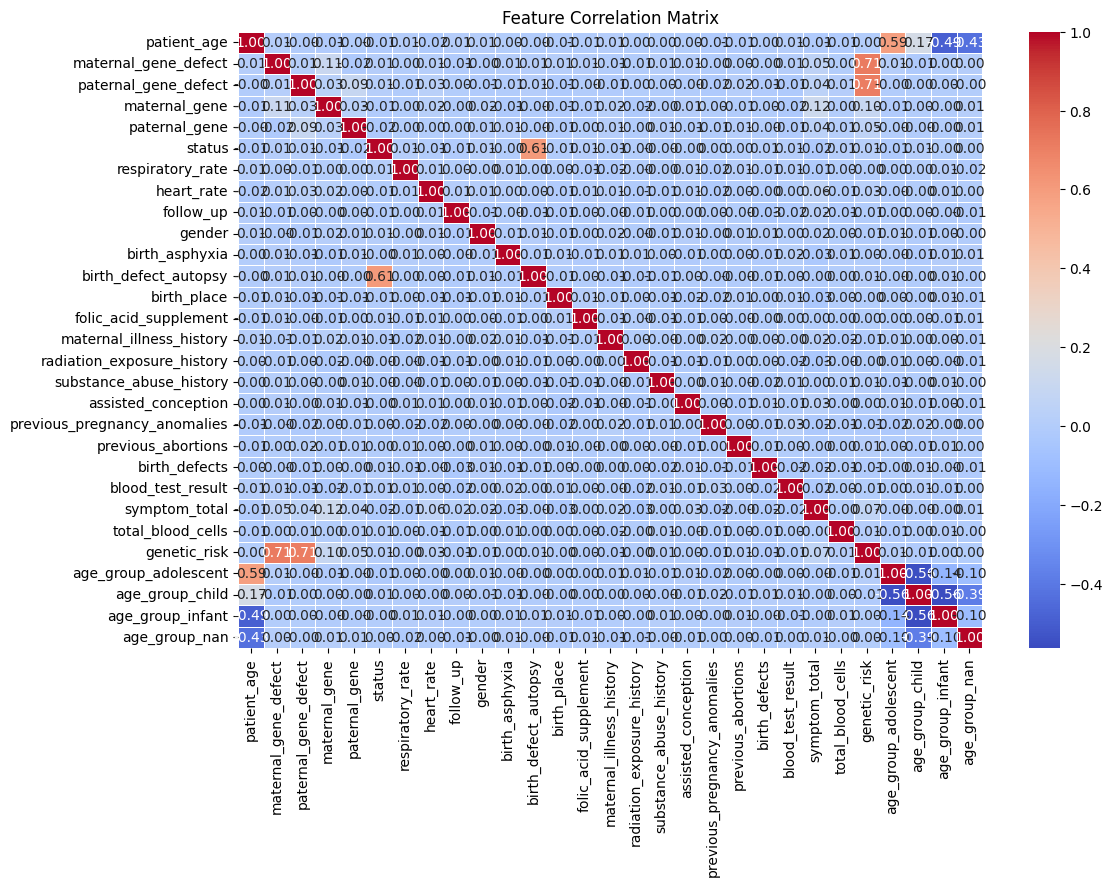

In [227]:
corr_matrix = X_train.corr()

# Print correlation matrix
print("Correlation Matrix:\n", corr_matrix)

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Feature Correlation Matrix")
plt.show()

In [222]:
print(X_train.shape,X_test.shape)

(15154, 29) (3789, 29)


In [223]:
from xgboost import XGBClassifier

xgb_classifier = XGBClassifier(
    max_depth=4,
    learning_rate=0.1,
    n_estimators=100,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='multi:softmax',
    num_class=len(label_encoder.classes_),
    random_state=42
)

xgb_classifier.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_class=9, ...)

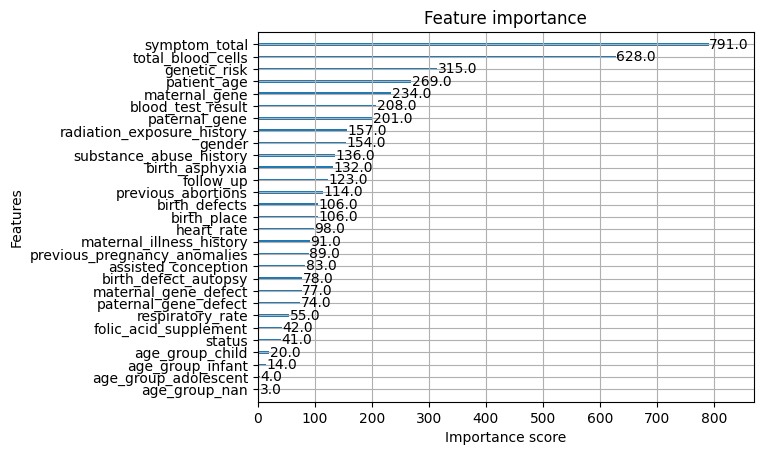

In [224]:
import matplotlib.pyplot as plt
xgb.plot_importance(xgb_classifier)
plt.show()


In [225]:
y_pred = xgb_classifier.predict(X_test)

train_accuracy = accuracy_score(y_train, xgb_classifier.predict(X_train))
test_accuracy = accuracy_score(y_test, y_pred)

In [226]:
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Train Accuracy: 0.6882
Test Accuracy: 0.6485


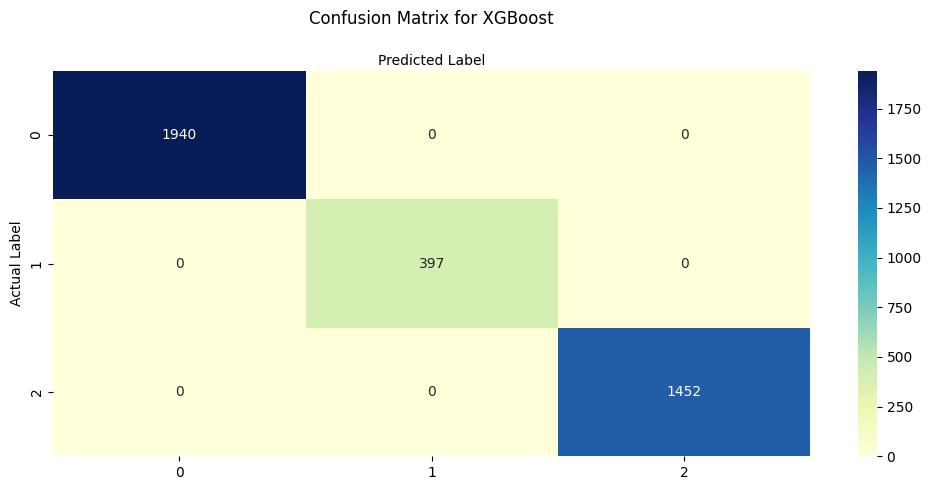

In [219]:
cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(10, 5))
sns.heatmap(cm, annot=True, cmap="YlGnBu", fmt='g')

plt.title(f'Confusion Matrix for XGBoost', y=1.1)
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')

plt.show()

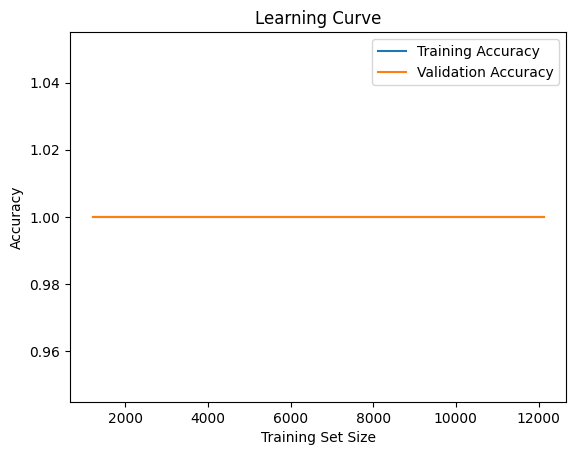

In [220]:
from sklearn.model_selection import learning_curve
import numpy as np

train_sizes, train_scores, test_scores = learning_curve(
    xgb_classifier, X_train, y_train, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10)
)

train_mean = train_scores.mean(axis=1)
test_mean = test_scores.mean(axis=1)

plt.plot(train_sizes, train_mean, label="Training Accuracy")
plt.plot(train_sizes, test_mean, label="Validation Accuracy")
plt.legend()
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.title("Learning Curve")
plt.show()


classifiers = {
    'Logistic Regression': LogisticRegression(C=10),
    'SVC': SVC(C=10,kernel='linear'),
    'Naive Bayes': GaussianNB(),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Decision Tree': DecisionTreeClassifier(max_depth=10),
    'Random Forest': RandomForestClassifier(n_estimators=15,max_depth=5),
    'AdaBoost': AdaBoostClassifier(n_estimators=50),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100),
    'XGBoost': XGBClassifier(n_estimators=100)

}

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd